# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
from numpy import linalg as la
# from scipy.optimize import curve_fit
from scipy import ndimage

%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD3L1D_STK(xAxis, tAxis, sigma_dict, tPara_ict, spaceDivideStep = 1, timeDivideStep = 60):
# divideStep upsample rate
# tPara_dict must include these temporal parameters: alpha, beta, gamma, g, h, l 
    dx = np.mean(np.diff(xAxis)) / spaceDivideStep
    xAxis = AxisByHalfLen(xAxis[-1], dx)
    gaussK = {} # Gassian Kernel
    for (key,value) in sigma_dict.items():
        halfKLen = min( value*8, xAxis[-1])
        kAxis = AxisByHalfLen(halfKLen, dx)
        gaussK[key] = Gaussian_filter_1d(kAxis,value)

    dt = np.mean(np.diff(tAxis)) / timeDivideStep
    tAxis = np.arange(0, tAxis[-1]+dt, dt)
    stimulus = np.zeros([len(tAxis), len(xAxis)])
    if "tau_delay" in tPara_ict:
        delayed_delta = tAxis /tPara_dict['tau_delay']/tPara_dict['tau_delay'] *np.exp(-tAxis/tPara_dict['tau_delay']) *dt
        stimulus[:,int(len(xAxis)/2)] = delayed_delta
    else:
        stimulus[0,int(len(xAxis)/2)] = 1

    for key in ['alpha','beta','gamma','m','n','g','h','l']: # initialize tPara_ict
        if not key in tPara_ict.keys(): 
            tPara_ict[key] = 1

    z = np.zeros_like(stimulus)
    y = np.zeros_like(stimulus)
    w = np.zeros_like(stimulus)

    for i in np.arange(len(tAxis)-1):
        R = {'s2y':stimulus[i,:], 'y2z':y[i,:], 'y2w':y[i,:], 'z2y':z[i,:], 'z2w':z[i,:]} # initialization
        for key in R.keys():
            if key in gaussK:    R[key] = np.convolve(R[key],gaussK[key],'same')*dx

        dy = (-tPara_dict['alpha']*y[i,:] + tPara_dict['m']*R['s2y'] - tPara_dict['n']*R['z2y'])*dt
        dz = (-tPara_dict['beta'] *z[i,:] + tPara_dict['g']*R['y2z']                           )*dt
        dw = (-tPara_dict['gamma']*w[i,:] + tPara_dict['h']*R['y2w'] - tPara_dict['l']*R['z2w'])*dt

        y[i+1,:] = (y[i,:]+dy)
        z[i+1,:] = (z[i,:]+dz)
        w[i+1,:] = (w[i,:]+dw)
    actual_xAxisIndex = np.append( np.arange(int(len(xAxis)/2), -1, -spaceDivideStep)[:0:-1], np.arange(int(len(xAxis)/2), len(xAxis), spaceDivideStep) )
    y = y[::timeDivideStep, actual_xAxisIndex]/dx/dt #
    z = z[::timeDivideStep, actual_xAxisIndex]/dx/dt
    w = w[::timeDivideStep, actual_xAxisIndex]/dx/dt

    return w, z, y

def AxisByHalfLen(halfLen, dx):
    axis = np.arange(0, halfLen+dx, dx)
    return np.append(-1*axis[:0:-1], axis)


# Set Parameter

In [4]:
# temporal
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':1.302408,
'beta':13.024075,
'gamma':34.901452,
'g':460.016331,
'l':0.021331,
'tau_delay':0.028650,
'm':127.832600} # m can be nagative for off cell

# spatial
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 
sigma_dict['y2z'] = 0.05*sigma_dict['y2w']   # has to be small enough

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) # Half length of xais, (mm)
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

# STK

In [5]:
Delta_output_w, zts, Delta_output_y = NGD3L1D_STK(SKxaxis, TKtaxis, sigma_dict, tPara_dict)
delSTK = Delta_output_w

iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
mag_Se2del = 1/np.max(SeSTK)*np.max(delSTK)
SeSTK = SeSTK*mag_Se2del

In [6]:
U,sigma,VT=la.svd(delSTK)
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[9.61498634e-01 3.84461338e-02 5.38562577e-05 1.36575741e-06
 9.63243521e-09]


In [7]:
STK = {}
STK['Ori'] = delSTK
STK['SbI'] = SeSTK # separated by integration
STK['SVD'] = SVDSTK

# SMB

In [8]:
def STconvolve(x, k:list, dx, dt):
    if len(k) == 1: # A spatial temporal kernel
        k = k[0]
        output = np.zeros([x.shape[0],max(k.shape[1], x.shape[1])])
        for i in range(x.shape[0]):
            for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
                output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
        return output
    if len(k) == 2: # Separated TK and SK
        TK = k[0]
        SK = k[1]
        output = np.zeros([x.shape[0],max(len(SK), x.shape[1])])
        for i in range(output.shape[0]):
            output[i, :] = np.convolve(x[i, :],SK,'same')*dx
        for j in range(output.shape[1]):
            output[:, j] = np.convolve(output[:, j],TK,'full')[:output.shape[0]]*dt
        return output

In [9]:
def SquareWave(width, dx): #width in mm
    halfWidth = int( (width/dx-1)/2 + 0.5) # halfWidth is dimensionless
    return np.ones(2*halfWidth+1), (2*halfWidth+1)*dx # return a square wave and the actual width of it

def GaussianWave(sigma, dx): # sigma is dimensionless
    s = sigma/dx # s is dimensionless
    xaxis = np.arange(-10*int(s), 10*int(s)+1)
    return (np.exp(-(xaxis/s)**2/2)) # return a Gaussian wave

def MasterConvolve(master, servant):
    if len(master)>=len(servant):
        return np.convolve(master, servant, 'same')
    else:
        output = np.convolve(master, servant, 'full')
        sHalfLen = int(len(servant)/2)
        return output[sHalfLen:-sHalfLen]

In [10]:
DR = 1.4 #mm
dDR = int(DR/dx+0.5)

Tto = 100
LPOUtaxis = np.arange(0,Tto,dt)
Fc_list = np.array([0.5,1,2,4])
LPOU_list = SSG(Fc_list, dt, Tto, tau = 1, D = 1)[:-1]
rsLPOU_list = [((LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*(dDR-1E-6) - dDR/2 ).astype(int) for LPOU in LPOU_list]

In [11]:
LPOU_bar_list = []
for rsLPOU in rsLPOU_list:
    LPOU_bar = np.zeros([len(rsLPOU),len(SKxaxis)])
    for i in range(len(rsLPOU)):
        LPOU_bar[i, rsLPOU[i]+hXstep+1] = 1
    LPOU_bar_list.append( LPOU_bar.copy() )

In [12]:
Responses = {}
Responses['Ori'] = [ STconvolve(LPOU_bar,[STK['Ori']],     dx,dt)             for LPOU_bar in LPOU_bar_list]
Responses['SbI'] = [ STconvolve(LPOU_bar,[ iTK, iSK ],     dx,dt)*mag_Se2del  for LPOU_bar in LPOU_bar_list]
Responses['SVD'] = [ STconvolve(LPOU_bar,[U[:,0], VT[0,:]],dx,dt)*sigma[0]    for LPOU_bar in LPOU_bar_list]

In [13]:
hw = 0.129
width = 0.133
squareWave, width = SquareWave(width, dx)

print('Effective width = '+str(width))
for STKtype in ['Ori', 'SbI', 'SVD']:
    Responses[STKtype] = [ np.array([np.convolve(r[i, :], squareWave, 'same') for i in range(LPOU_bar.shape[0])])  for r in Responses[STKtype] ]

Effective width = 0.135


## Without gain control

In [14]:
CellIndex = 400 # center index
cellResponses = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    cellResponses[STKtype] = [r[:, CellIndex] for r in Responses[STKtype]]

In [15]:
tv_list = [ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt  for LPOU in LPOU_list]
#assign states
state_num = 6
xstate_list = [EqualState(LPOU, state_num)[0] for LPOU in LPOU_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

rstates = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    rstates[STKtype] = [SG(r, dt, 0, 2, 10) for r in cellResponses[STKtype]]

In [16]:
window = [-1, 1]
MIs = {}
for STKtype in ['Ori', 'SbI', 'SVD']:
    MIs[STKtype] = [0]*len(LPOU_list)
    for i in range(len(LPOU_list)):
        timeshift, MIs[STKtype][i] = MIfunc(rstates[STKtype][i], xstate_list[i], dt, window)

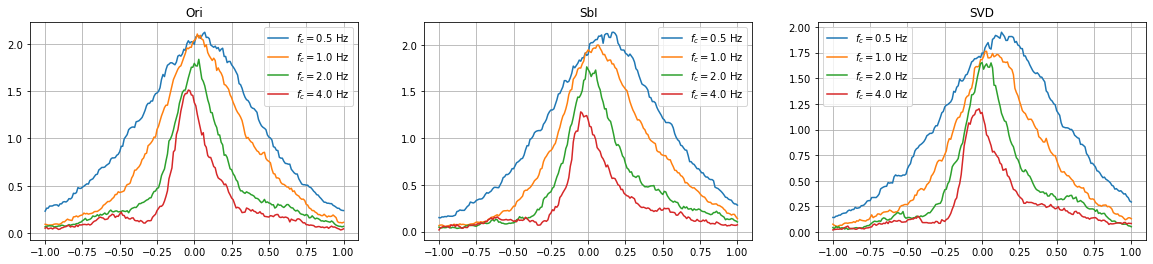

In [17]:
fig, ax = plt.subplots(1,3)
j = 0
for STKtype in ['Ori', 'SbI', 'SVD']:
    for i in range(len(LPOU_list)):
        ax[j].plot(timeshift, MIs[STKtype][i], label = r'$f_c=$'+str(Fc_list[i])+' Hz')
    ax[j].set_title(STKtype)
    ax[j].legend()
    ax[j].grid('on')
    j += 1
fig.set_size_inches(20,4)